In [1]:
import numpy as np
import torch
import torchvision
import torchmetrics
import lightning.pytorch as pl 
from torchinfo import summary 
from torchview import draw_graph 
import matplotlib.pyplot as plt 
import pandas as pd

if (torch.cuda.is_available()): 
    device = ("cuda")
else:
    device = ("cpu")
print(f"Use GPU: {torch.cuda.is_available()}")

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


Use GPU: False


In [26]:
# Config Section

cfg_data_folder = "datasets/cifar10"
# cfg_log_folder = "logs"
# cfg_log_version = "cifar10"

cfg_max_epochs = 10
cfg_hidden_dim = 42

cfg_cifar10_labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

cfg_num_workers = 5


In [3]:
# Load the data set and scale to [-1,+1]
training_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder, download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder,  download=True, train=False) 

x_train = (torch.Tensor(training_dataset.data) / 127.5) - 1.0
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
x_test = (torch.Tensor(testing_dataset.data) / 127.5) - 1.0 
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)

# You can set a seed value here if you
# want to control the shuffling process...
rng = np.random.default_rng()
permutation = rng.permutation(x_train.shape[0]) 
split_point = int(x_train.shape[0] * 0.8) # 80%/20% split

# Split into validation/training - keep test # set aside for later...
x_val = x_train[permutation][split_point:]
y_val = y_train[permutation][split_point:]
x_train = x_train[permutation][:split_point]
y_train = y_train[permutation][:split_point]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:15<00:00, 11286653.87it/s]


Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified
torch.Size([40000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])


In [4]:
x_train.shape

torch.Size([40000, 32, 32, 3])

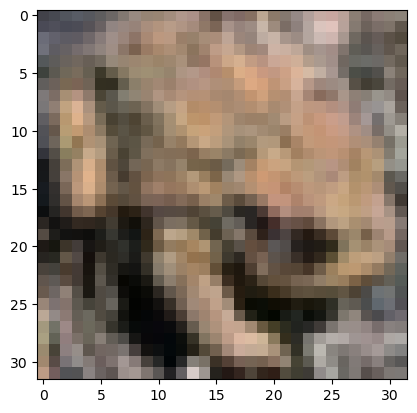

Label: Frog (idx: 6)


In [5]:
plt.imshow((x_train[0].detach().numpy() + 1.0)/2.0)
plt.show()
print(f"Label: {cfg_cifar10_labels.get(int(y_train[0]))} (idx: {y_train[0]})")

In [9]:
# Define model
class WideNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.flatten_layer = torch.nn.Flatten()
        self.hidden_layer = torch.nn.Linear(input_size.numel(),
                                            hidden_size)
        self.hidden_activation = torch.nn.Tanh()
        self.output_layer = torch.nn.Linear(hidden_size,
                                            output_size)
    
    def forward(self, x):
        y = x
        y = self.flatten_layer(y)
        y = self.hidden_activation(self.hidden_layer(y))
        y = self.output_layer(y)
        return y
        
    def predict(self, x):
        y = x
        y = self.forward(y)
        y = torch.softmax(y, -1)
        return y

In [11]:
# Define Trainable Module
class PLModel(pl.LightningModule):
    def __init__(self, module, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments. 
        super().__init__(**kwargs) # Call the super class constructor 
        self.module = module
        
        # This creates an accuracy function
        self.model_acc = torchmetrics.classification.Accuracy(task='multiclass', 
                                                              num_classes=module.output_layer.out_features)
        # This creates a loss function
        self.model_loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.module.forward(x) 
        
    def predict(self, x):
        return self.module.predict(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true) 
        self.log('train_acc',  acc,  on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss


    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true)
        self.log('val_acc',  acc,  on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred,y_true)
        loss = self.model_loss(y_pred,y_true)
        self.log('test_acc',  acc,  on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [27]:
print(f"Hidden Dims: {cfg_hidden_dim}")

model = PLModel(WideNetwork(x_train.shape[1:],
                            len(y_train.unique()),
                            cfg_hidden_dim))

summary(model, input_size=(1,)+x_train.shape[1:])

Hidden Dims: 42


Layer (type:depth-idx)                   Output Shape              Param #
PLModel                                  [1, 10]                   --
├─WideNetwork: 1-1                       --                        --
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Linear: 2-2                       [1, 42]                   129,066
│    └─Tanh: 2-3                         [1, 42]                   --
│    └─Linear: 2-4                       [1, 10]                   430
Total params: 129,496
Trainable params: 129,496
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.13
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.52
Estimated Total Size (MB): 0.53

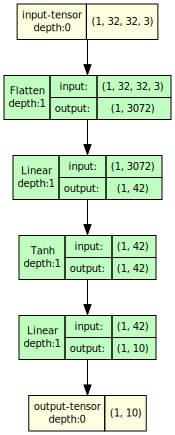

In [28]:
# Depth Setting
model_graph = draw_graph(model, input_size=(1,)+x_train.shape[1:], device=device, depth=3)

model_graph.visual_graph

In [29]:
predictions = model.predict(x_train[:5].to(device)).cpu().detach().numpy()

predictions

array([[0.10742779, 0.10917261, 0.09149612, 0.09663166, 0.10427158,
        0.10397827, 0.1002244 , 0.1036239 , 0.08067065, 0.10250296],
       [0.11174151, 0.09234022, 0.10517874, 0.10209792, 0.10735616,
        0.09910303, 0.10174479, 0.1098918 , 0.08133986, 0.089206  ],
       [0.08638343, 0.08890687, 0.10838497, 0.12381352, 0.11693097,
        0.08176555, 0.10216247, 0.11481797, 0.07492343, 0.10191078],
       [0.1038752 , 0.08534758, 0.1145028 , 0.1025007 , 0.10404223,
        0.10240413, 0.08380121, 0.12916481, 0.0820356 , 0.09232568],
       [0.1261484 , 0.09501011, 0.06317191, 0.09246987, 0.10350075,
        0.12558798, 0.08576679, 0.1302333 , 0.09298202, 0.08512884]],
      dtype=float32)

In [30]:
model.model_loss(model(x_train[:5].to(device)),
                 y_train[:5].to(device)
                ).cpu().detach().numpy()

array(2.1980531, dtype=float32)

In [31]:
model.model_acc(model(x_train[:5].to(device)),
                y_train[:5].to(device)).cpu().detach().numpy()

array(0.2, dtype=float32)

In [32]:
xy_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)),
                                       shuffle=True,
                                       batch_size=250,
                                       num_workers=cfg_num_workers) # Using CFG

xy_val = torch.utils.data.DataLoader(list(zip(x_val, y_val)),
                                     shuffle=False,
                                     batch_size=250,
                                     num_workers=cfg_num_workers) # Using CFG

xy_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                      shuffle=False,
                                      batch_size=250,
                                      num_workers=cfg_num_workers) # Using CFG

In [33]:
# Setup Logger
logger = pl.loggers.CSVLogger("logs", name="OL2", version="wide")

In [34]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.10090000182390213    │
│         val_loss          │     2.30700421333313      │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.10090000182390213, 'val_loss': 2.30700421333313}]

In [36]:
trainer.fit(model, xy_train, xy_val)


  | Name       | Type               | Params
--------------------------------------------------
0 | module     | WideNetwork        | 129 K 
1 | model_acc  | MulticlassAccuracy | 0     
2 | model_loss | CrossEntropyLoss   | 0     
--------------------------------------------------
129 K     Trainable params
0         Non-trainable params
129 K     Total params
0.518     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [37]:
# Validate on Model
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.44269999861717224    │
│         val_loss          │     1.618436574935913     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.44269999861717224, 'val_loss': 1.618436574935913}]

In [38]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.1009,2.307004,0,0,NaN,NaN
1,0.3915,1.740269,0,159,NaN,NaN
2,NaN,NaN,0,159,0.369825,1.817250
3,0.4154,1.681520,1,319,NaN,NaN
4,NaN,NaN,1,319,0.419975,1.687382
5,0.4206,1.669823,2,479,NaN,NaN
6,NaN,NaN,2,479,0.437150,1.636469
7,0.4315,1.632822,3,639,NaN,NaN
8,NaN,NaN,3,639,0.451375,1.592776
9,0.4349,1.634647,4,799,NaN,NaN


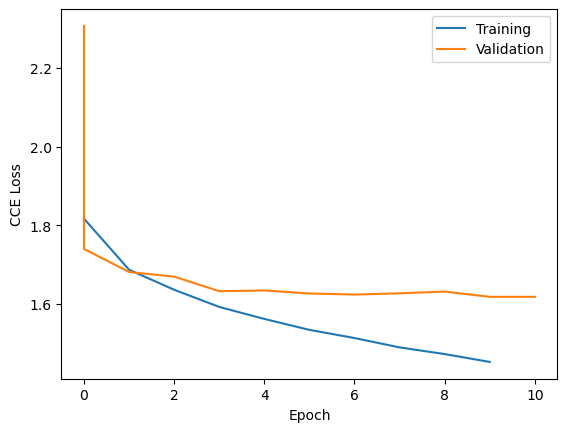

In [39]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

In [40]:
print("Validation accuracy:",*["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])

Validation accuracy: 0.10090000 0.39150000 0.41540000 0.42060000 0.43149999 0.43489999 0.43560001 0.43970001 0.43560001 0.43520001 0.44270000 0.44270000


In [41]:
print("Testing accuracy:", trainer.test(model, xy_test)[0]['test_acc'])

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4392000138759613     │
│         test_loss         │    1.6192259788513184     │
└───────────────────────────┴───────────────────────────┘

Testing accuracy: 0.4392000138759613
